# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

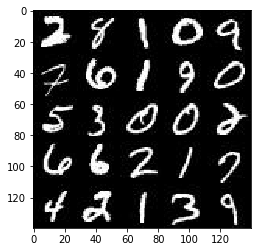

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

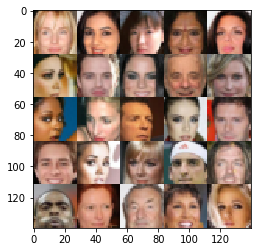

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input variable 28x28x-1
        
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Output layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fc, project
        fc1 = tf.layers.dense(z, 7*7*1024)
        
        # Reshape for convolution
        reshaped = tf.reshape(fc1, (-1, 7, 7, 1024))
        bn1 = tf.layers.batch_normalization(reshaped, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x1024
        
        conv2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x512
        
        conv3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x256
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xoutput_dim
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Weights & Bias
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    out_channel_dim = data_shape[3]

    show_every = 100
    print_every = 10
    
    samples = []
    losses = []
    steps = 0
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    
    with tf.Session() as sess:
        
        input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                # Random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                
                if steps % print_every == 0:                   
                    # Get the losses, print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3246... Generator Loss: 1.7229
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 0.1232... Generator Loss: 3.1592
Epoch 1/2... Discriminator Loss: 0.1080... Generator Loss: 4.6269
Epoch 1/2... Discriminator Loss: 0.1966... Generator Loss: 2.9227
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.4350
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.4285
Epoch 1/2... Discriminator Loss: 0.2261... Generator Loss: 2.7628
Epoch 1/2... Discriminator Loss: 0.7024... Generator Loss: 1.7695
Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 1.8665


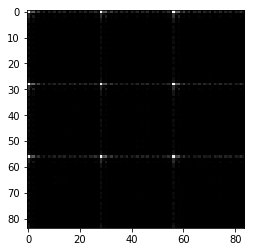

Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 3.6072
Epoch 1/2... Discriminator Loss: 0.5922... Generator Loss: 1.9040
Epoch 1/2... Discriminator Loss: 0.5692... Generator Loss: 2.8848
Epoch 1/2... Discriminator Loss: 0.3804... Generator Loss: 1.6771
Epoch 1/2... Discriminator Loss: 0.2967... Generator Loss: 2.7219
Epoch 1/2... Discriminator Loss: 0.2811... Generator Loss: 2.8932
Epoch 1/2... Discriminator Loss: 0.1572... Generator Loss: 2.6950
Epoch 1/2... Discriminator Loss: 0.1250... Generator Loss: 2.7785
Epoch 1/2... Discriminator Loss: 0.1732... Generator Loss: 2.7373
Epoch 1/2... Discriminator Loss: 0.1103... Generator Loss: 2.7192


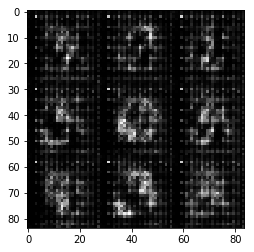

Epoch 1/2... Discriminator Loss: 0.0783... Generator Loss: 3.1859
Epoch 1/2... Discriminator Loss: 0.0420... Generator Loss: 4.0295
Epoch 1/2... Discriminator Loss: 0.0734... Generator Loss: 3.8472
Epoch 1/2... Discriminator Loss: 0.2939... Generator Loss: 4.5913
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 1.2498
Epoch 1/2... Discriminator Loss: 0.1695... Generator Loss: 2.7843
Epoch 1/2... Discriminator Loss: 0.1732... Generator Loss: 3.1089
Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 2.9342
Epoch 1/2... Discriminator Loss: 0.2503... Generator Loss: 2.4058
Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 5.9296


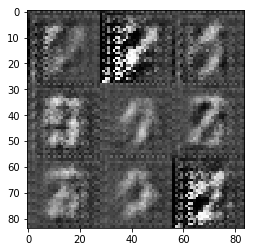

Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 5.3313
Epoch 1/2... Discriminator Loss: 0.2617... Generator Loss: 2.5939
Epoch 1/2... Discriminator Loss: 0.2150... Generator Loss: 2.8088
Epoch 1/2... Discriminator Loss: 0.2707... Generator Loss: 2.5291
Epoch 1/2... Discriminator Loss: 2.0643... Generator Loss: 0.3358
Epoch 1/2... Discriminator Loss: 0.8096... Generator Loss: 3.8097
Epoch 1/2... Discriminator Loss: 0.6648... Generator Loss: 5.0375
Epoch 1/2... Discriminator Loss: 0.3108... Generator Loss: 2.7624
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.7405
Epoch 1/2... Discriminator Loss: 0.2107... Generator Loss: 2.2925


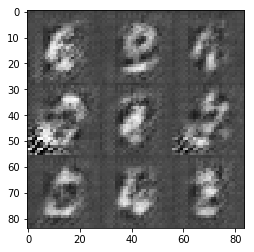

Epoch 1/2... Discriminator Loss: 0.4301... Generator Loss: 1.9449
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 4.3436
Epoch 1/2... Discriminator Loss: 0.7084... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 0.4379... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 0.1253... Generator Loss: 3.2814
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 0.8504... Generator Loss: 1.3169
Epoch 2/2... Discriminator Loss: 0.3856... Generator Loss: 1.3968
Epoch 2/2... Discriminator Loss: 0.2524... Generator Loss: 4.9236
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 0.8296


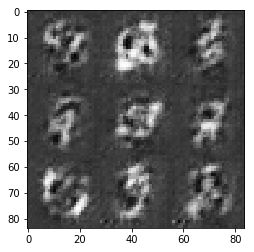

Epoch 2/2... Discriminator Loss: 0.2827... Generator Loss: 1.6942
Epoch 2/2... Discriminator Loss: 0.2641... Generator Loss: 1.8085
Epoch 2/2... Discriminator Loss: 0.0862... Generator Loss: 3.3227
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 1.9030
Epoch 2/2... Discriminator Loss: 0.2501... Generator Loss: 2.2428
Epoch 2/2... Discriminator Loss: 0.1864... Generator Loss: 3.0721
Epoch 2/2... Discriminator Loss: 0.1947... Generator Loss: 2.1624
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 0.2016... Generator Loss: 2.0596


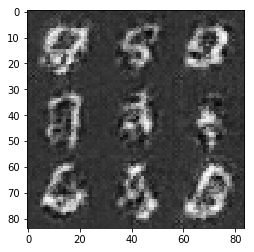

Epoch 2/2... Discriminator Loss: 0.2276... Generator Loss: 3.3230
Epoch 2/2... Discriminator Loss: 0.4495... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 0.4081... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.0878... Generator Loss: 3.2837
Epoch 2/2... Discriminator Loss: 2.0306... Generator Loss: 0.1999
Epoch 2/2... Discriminator Loss: 0.7190... Generator Loss: 2.8152
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 1.5099
Epoch 2/2... Discriminator Loss: 0.1974... Generator Loss: 2.0798


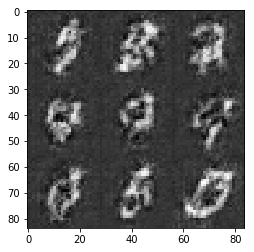

Epoch 2/2... Discriminator Loss: 0.2062... Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 0.1427... Generator Loss: 2.5256
Epoch 2/2... Discriminator Loss: 0.0564... Generator Loss: 4.8431
Epoch 2/2... Discriminator Loss: 0.3057... Generator Loss: 1.5593
Epoch 2/2... Discriminator Loss: 5.8849... Generator Loss: 10.4971
Epoch 2/2... Discriminator Loss: 0.5599... Generator Loss: 1.3128
Epoch 2/2... Discriminator Loss: 0.3557... Generator Loss: 1.6322
Epoch 2/2... Discriminator Loss: 0.2434... Generator Loss: 2.1261
Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.4482


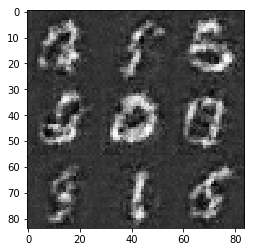

Epoch 2/2... Discriminator Loss: 0.2892... Generator Loss: 1.7030
Epoch 2/2... Discriminator Loss: 0.3251... Generator Loss: 1.5775
Epoch 2/2... Discriminator Loss: 0.2707... Generator Loss: 1.7378
Epoch 2/2... Discriminator Loss: 0.1155... Generator Loss: 2.7909
Epoch 2/2... Discriminator Loss: 0.2759... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 0.1031... Generator Loss: 2.9252
Epoch 2/2... Discriminator Loss: 0.0481... Generator Loss: 4.9692
Epoch 2/2... Discriminator Loss: 0.4816... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 4.3750
Epoch 2/2... Discriminator Loss: 0.1904... Generator Loss: 2.1347


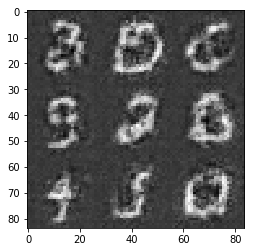

Epoch 2/2... Discriminator Loss: 0.1251... Generator Loss: 2.5463
Epoch 2/2... Discriminator Loss: 0.0246... Generator Loss: 4.7895
Epoch 2/2... Discriminator Loss: 0.5948... Generator Loss: 2.2965


In [56]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2009... Generator Loss: 0.1301
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 2.7617
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 1.7339
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 0.8201


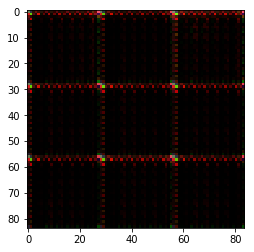

Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.3410
Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 2.9703
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.2812... Generator Loss: 2.0036
Epoch 1/1... Discriminator Loss: 0.3017... Generator Loss: 3.1603
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 3.0838
Epoch 1/1... Discriminator Loss: 0.0891... Generator Loss: 4.4323
Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 2.1536


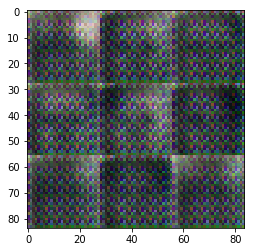

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 2.8955
Epoch 1/1... Discriminator Loss: 3.0479... Generator Loss: 4.1636
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 3.1364
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 3.1589
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 2.2006
Epoch 1/1... Discriminator Loss: 0.1514... Generator Loss: 4.5427
Epoch 1/1... Discriminator Loss: 1.7921... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 8.6222


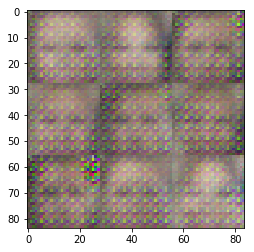

Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 2.2087
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 0.2768... Generator Loss: 3.2676
Epoch 1/1... Discriminator Loss: 0.0945... Generator Loss: 5.5325
Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 0.0827... Generator Loss: 5.6680
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 5.4966
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 2.3192
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 0.5741


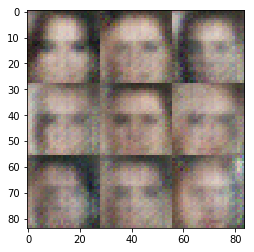

Epoch 1/1... Discriminator Loss: 2.3626... Generator Loss: 0.2800
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.9806
Epoch 1/1... Discriminator Loss: 0.1926... Generator Loss: 2.8362
Epoch 1/1... Discriminator Loss: 0.2501... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 6.0467
Epoch 1/1... Discriminator Loss: 0.1174... Generator Loss: 5.2610
Epoch 1/1... Discriminator Loss: 0.2593... Generator Loss: 2.2050
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 1.8527
Epoch 1/1... Discriminator Loss: 0.2550... Generator Loss: 5.5562
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 5.2366


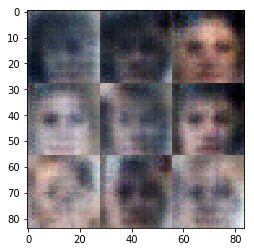

Epoch 1/1... Discriminator Loss: 0.0438... Generator Loss: 10.1547
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 6.9650
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 5.0910
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 0.1526... Generator Loss: 6.2357
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 4.7087
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 2.6338


KeyboardInterrupt: 

In [58]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.